<a href="https://colab.research.google.com/github/letyrodridc/Deep-Reinforcement-Learning/blob/master/dqn/CartPole_DQN_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Solving the CartPole problem using a DQN

---



In [0]:
USE_COLAB = True


In [2]:
## Open AI Gym
!pip install gym
!pip -q install pyglet
!pip -q install pyvirtualdisplay
!apt-get install python-opengl
!apt-get install xvfb



from pyvirtualdisplay import Display
import os


display = Display(visible=0, size=(1024, 768))
display.start()

os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl
0 upgraded, 1 newly installed, 0 to remove and 7 not upgraded.
Need to get 496 kB of archives.
After this operation, 5,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Fetched 496 kB in 1s (679 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 135004 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Setting up python-opengl (3.1.0+dfsg-1) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The f

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


In [0]:
import gym       # Librería OpenAI 
import random
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML

In [4]:
env = gym.make('CartPole-v1')
env.seed(0) # El entorno precisa definir una semilla para la aleatoriedad

[0]

In [5]:
action_space = env.action_space              # Obtenemos la cantidad de elementos del espacio de acciones (action space)
observation_space = env.observation_space    # Obtenemos la cantidad de elementos del espacio de estados (state space)

## Obtengo la cantidad de acciones en un entero tipo int
actions_len = action_space.n
states_len = observation_space.shape[0]

print("Actions: ", action_space)
print("States: ", observation_space)

Actions:  Discrete(2)
States:  Box(4,)


In [6]:

episodes = 10 # It will try for 10 episodes

rewards = list()

frames = list() 

for g in range(0, episodes):
    
    # Arranca de nuevo, resetea el entorno
    initial_state = env.reset()
    episode_reward = 0
    
    #print("Estado Inicial:", initial_state)
   
    while(True):
        # Renders the environment. If we are using colab, it will save the frames for later animation.
        if USE_COLAB:
            frames.append(env.render(mode = 'rgb_array'))
        else:
            env.render()
          
        # Chooses a random action
        action = action_space.sample()
        
        
        # Takes the action
        next_state, reward, done, _ = env.step(action)
        
        episode_reward += reward

        
        if done:
            rewards.append(episode_reward)
            print("Episode: ",g+1, " Total rewards: ", episode_reward)
            break

env.close()

# Print rewards average
print("Rewards Average: ", np.mean(rewards))

Episode:  1  Total rewards:  19.0
Episode:  2  Total rewards:  11.0
Episode:  3  Total rewards:  21.0
Episode:  4  Total rewards:  19.0
Episode:  5  Total rewards:  15.0
Episode:  6  Total rewards:  17.0
Episode:  7  Total rewards:  32.0
Episode:  8  Total rewards:  12.0
Episode:  9  Total rewards:  26.0
Episode:  10  Total rewards:  22.0
Rewards Average:  19.4


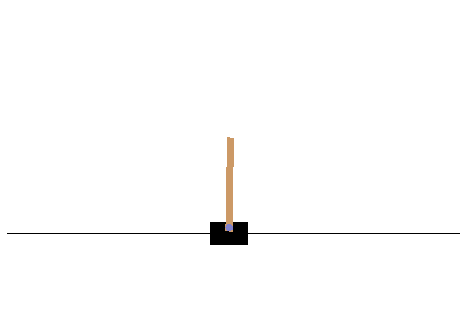

In [7]:
## SOLO COLAB
plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(ani.to_jshtml())

## DQN algorithm for learning how to solve the CartPole environment
---

In [0]:
import random
class ReplayBuffer:
  ### FIFO Buffer

  def __init__(self, buffer_size):
    self.buffer_size = buffer_size
    self.buffer = list()

  def add(self, element):
    if len(self.buffer) == self.buffer_size:
      self.buffer.pop(0)
    self.buffer.append(element)

  def sample(self, size):
    return random.choices(self.buffer,k=min(len(self.buffer), size))

  def size(self):
    return len(self.buffer)

  def capacity(self):
    return self.buffer_size
    

  

In [9]:
r = ReplayBuffer(3)


r.add(1)
r.add(2)
r.add(3)
r.add(4)

print(r.buffer)

[2, 3, 4]


In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

class DQN:

  def __init__(self, input_shape, output_shape):
    self.input_shape = input_shape
    self.output_shape = output_shape
    self.model = Sequential()
    self.model.add(Dense(64, input_shape=(input_shape,), activation="relu"))
    self.model.add(Dense(64, activation="relu"))
    #self.model.add(Dense(128))
    self.model.add(Dense(output_shape), activation="linear")
    self.model.compile(optimizer=Adam(lr=0.001), loss="mse")

  def train(self,X,y):
   
    X = X.reshape([1,self.input_shape])
    self.model.fit(X,y, epochs=1, verbose=0)



  def predict(self,X):
    X = X.reshape([1,self.input_shape])
    return self.model.predict(X)





In [0]:
import numpy as np

class DQN_algorithm():

  def __init__(self, env):
    self.buffer = ReplayBuffer(1000000)
    self.episodes = 200
    self.sample = 200
    self.env = env
    self.epsilon = 0.1
    self.action_space = env.action_space.n
    self.obs_space = env.observation_space.shape[0]
    self.Q = DQN(self.obs_space, self.action_space)
    self.gamma = 0.95
    self.EXPLORATION_MAX = 1.0
    self.EXPLORATION_MIN = 0.01
    self.EXPLORATION_DECAY = 0.995
    self.exploration_rate = self.EXPLORATION_MAX
    self.policy = self.e_greedy_policy

  def train(self):
    
    self.env.seed(0)

    for i in range(self.episodes):
      state = self.env.reset()
      episode_reward = 0
      
      while(True):
        action = self._get_next_action(state)
        next_state, reward, done, _ = env.step(action) 
        episode_reward += reward

        self.buffer.add( (state, action, reward, next_state, done) )
        
        self.exploration_rate = max(self.EXPLORATION_MIN, self.exploration_rate*self.EXPLORATION_DECAY)

        state = next_state

        if self.buffer.size() >= self.sample:
          sample = self.buffer.sample(self.sample)  

          for s in sample:
            self._update_policy(*s)
        if done:
          print("Episode: ",i+1, " Total rewards: ", episode_reward)
          break

  def get_next_action(self, state):
      return np.argmax(self.Q.predict(state)[0])

  def _get_next_action(self, state):
      return self.policy(state)
 
  def e_greedy_policy(self, state):
    target_action = self.get_next_action(state)

    p = [0.0 for i in range(actions_len)]
    
    for action in range(actions_len):
      if action == target_action:
        p[action] = 1.0-self.epsilon+(self.epsilon/actions_len)
      else:
        p[action] = (self.epsilon/actions_len)
    
    return np.random.choice(actions_len, p=p)
   
  def exploration_decay_policy(self, state):

    # Obtiene un número aleatorio para decir si tiene que explorar o explotar
    if np.random.rand() < self.exploration_rate:
        return random.randrange(self.action_space)

    return self.get_next_action(state)

  def _update_policy(self, state, action, reward, next_state, done):
 
 
    predicted_actions = self.Q.predict(state)
    predicted_next_actions = self.Q.predict(next_state)

    y = predicted_actions
    y[0][action] = reward + self.gamma*np.max(predicted_next_actions[0])*(1-done)
    X = state

    self.Q.train(X,y)

  


In [41]:
D = DQN_algorithm(env)
D.train()


Episode:  1  Total rewards:  10.0
Episode:  2  Total rewards:  11.0
Episode:  3  Total rewards:  12.0
Episode:  4  Total rewards:  15.0
Episode:  5  Total rewards:  12.0
Episode:  6  Total rewards:  9.0
Episode:  7  Total rewards:  27.0
Episode:  8  Total rewards:  9.0
Episode:  9  Total rewards:  11.0
Episode:  10  Total rewards:  9.0
Episode:  11  Total rewards:  9.0
Episode:  12  Total rewards:  22.0
Episode:  13  Total rewards:  8.0
Episode:  14  Total rewards:  10.0
Episode:  15  Total rewards:  21.0
Episode:  16  Total rewards:  12.0
Episode:  17  Total rewards:  9.0
Episode:  18  Total rewards:  11.0
Episode:  19  Total rewards:  11.0
Episode:  20  Total rewards:  27.0
Episode:  21  Total rewards:  17.0
Episode:  22  Total rewards:  61.0
Episode:  23  Total rewards:  37.0
Episode:  24  Total rewards:  76.0
Episode:  25  Total rewards:  104.0
Episode:  26  Total rewards:  111.0
Episode:  27  Total rewards:  122.0
Episode:  28  Total rewards:  123.0
Episode:  29  Total rewards:  1

KeyboardInterrupt: ignored